<a href="https://colab.research.google.com/github/paulynamagana/AFDB_notebooks/blob/main/afdb_msa_coverage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color='#2895ef'> Analysing AlphaFold's Database Multiple Sequence Alignments (MSAs) for coverage

AlphaFold structure predictions rely heavily on evolutionary information extracted from a multiple sequence alignment (MSA). The MSA provides evidence about which residues are conserved, which positions tend to vary together, and which regions of a protein are supported by homologous sequences across evolution. In practice, this evolutionary signal is a major determinant of model confidence.

However, not all MSAs are equally informative. An MSA may contain thousands of sequences but still provide limited evolutionary insight if those sequences are highly redundant or if large regions of the query sequence are poorly covered. As a result, simply knowing the total number of sequences in an MSA is often insufficient to understand why certain regions of an AlphaFold model are predicted with high confidence while others are not.

This notebook focuses on analysing MSA coverage at the residue level for MSAs provided in the AlphaFold Database. By quantifying how many sequences contribute information at each aligned position, we can identify regions that are well supported by evolutionary data and regions where AlphaFold is likely extrapolating with limited evidence.

By the end of this notebook, you will be able to:

* Assess how MSA coverage varies along a protein sequence.
* Relate local MSA support to AlphaFold confidence metrics such as pLDDT.
* Identify regions that are likely to correspond to conserved domains, flexible linkers, insertions, or poorly supported termini.
* Use MSA coverage as a diagnostic tool to interpret AlphaFold models more cautiously and decide when further modelling or MSA refinement may be necessary.

This analysis does not attempt to re-run AlphaFold or modify its predictions. Instead, it provides a practical framework for understanding why a given prediction is confident or uncertain, based on the evolutionary information available to the model.

## <font color='#2895ef'>**Background**

**What is an MSA?**

A Multiple Sequence Alignment (MSA) is a collection of evolutionarily related protein sequences aligned such that homologous residues are placed in the same columns. Conserved columns indicate positions under strong evolutionary constraint, while variable or poorly covered columns often correspond to flexible regions, insertions, or lineage-specific features.

**MSA quality: depth, diversity, and bias**

Not all MSAs contribute the same amount of information to structure prediction.

- Deep and diverse MSAs contain many evolutionarily independent homologs that span a range of sequence variation. These MSAs provide strong co-evolutionary constraints and typically support high-confidence predictions.

- Shallow MSAs (few homologs) or biased MSAs (many near-identical sequences) contain less independent evolutionary information. In these cases, AlphaFold relies more heavily on learned structural priors and single-sequence features, which can lead to lower confidence scores or overconfident local secondary structure in poorly supported regions.

Importantly, the total number of sequences in an MSA does not necessarily reflect its usefulness: hundreds of highly similar sequences may provide less information than a smaller but more diverse alignment.



---



- **What is an MSA?** A Multiple Sequence Alignment (MSA) is a collection of evolutionarily related protein sequences that have been aligned to highlight conserved positions and evolutionary changes. For AlphaFold, the MSA is the primary input, second only to the query sequence itself.



In [ ]:
#@title #1.&nbsp; Import and install libraries
!pip install -q py3Dmol biopython

import json
import requests
import re
import py3Dmol
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from IPython.display import display, Image
from io import StringIO
from Bio import AlignIO

print("----All packages imported successfully---")

----All packages imported successfully---


##2.&nbsp; Fetch prediction summary from AFDB API

First, we query the AFDB API for our target UniProt ID to get a summary of all available models, including isoforms.

In [ ]:
uniprot_id =  "Q92794" #@param {type:"string"}

url_pdb_prediction = f"https://alphafold.ebi.ac.uk/api/prediction/{uniprot_id.strip()}"

try:
    response = requests.get(url_pdb_prediction, timeout=20)
    if response.status_code == 200:
        result = response.json()
        print(json.dumps(result, indent=2))
    else:
        print(f"Error getting prediction for {uniprot_id}")
except requests.RequestException as e:
    print(f"Error during request: {e}")

[
  {
    "toolUsed": "AlphaFold Monomer v2.0 pipeline",
    "providerId": "GDM",
    "entityType": "protein",
    "isUniProt": true,
    "modelEntityId": "AF-Q92794-F1",
    "modelCreatedDate": "2025-08-01T00:00:00Z",
    "sequenceVersionDate": "2008-11-25T00:00:00Z",
    "globalMetricValue": 48.66,
    "fractionPlddtVeryLow": 0.699,
    "fractionPlddtLow": 0.03,
    "fractionPlddtConfident": 0.102,
    "fractionPlddtVeryHigh": 0.169,
    "latestVersion": 6,
    "allVersions": [
      1,
      2,
      3,
      4,
      5,
      6
    ],
    "sequence": "MVKLANPLYTEWILEAIKKVKKQKQRPSEERICNAVSSSHGLDRKTVLEQLELSVKDGTILKVSNKGLNSYKDPDNPGRIALPKPRNHGKLDNKQNVDWNKLIKRAVEGLAESGGSTLKSIERFLKGQKDVSALFGGSAASGFHQQLRLAIKRAIGHGRLLKDGPLYRLNTKATNVDGKESCESLSCLPPVSLLPHEKDKPVAEPIPICSFCLGTKEQNREKKPEELISCADCGNSGHPSCLKFSPELTVRVKALRWQCIECKTCSSCRDQGKNADNMLFCDSCDRGFHMECCDPPLTRMPKGMWICQICRPRKKGRKLLQKKAAQIKRRYTNPIGRPKNRLKKQNTVSKGPFSKVRTGPGRGRKRKITLSSQSASSSSEEGYLERIDGLDFCRDSNVSLKFNKKTKGLIDGLTKFFTPSPDGRKARGEVVDYSEQYR

In [ ]:
#@markdown This code block will print a table of all available entries for that UniProt ID, which can include isoforms.

# count how many isoforms
import pandas as pd

print(f"All entries for the UniProt ID {uniprot_id}:")

rows= []

for item in result:
    modelID = item.get("modelEntityId")
    description = item.get("uniprotDescription")
    latestVersion = item.get("latestVersion")
    average_plddt = item.get("globalMetricValue")
    fractionPlddtVeryLow = item.get("fractionPlddtVeryLow")
    fractionPlddtLow = item.get("fractionPlddtLow")
    fractionPlddtConfident = item.get("fractionPlddtConfident")
    fractionPlddtVeryHigh = item.get("fractionPlddtVeryHigh")

    rows.append({
        "model_ID": modelID,
        "description":description,
        "average_plddt": average_plddt,
        "latest_version": latestVersion,
        "fractionPlddtVeryLow": "{:.1f}%".format(fractionPlddtVeryLow * 100),
        "fractionPlddtLow": "{:.1f}%".format(fractionPlddtLow* 100),
        "fractionPlddtConfident": "{:.1f}%".format(fractionPlddtConfident* 100),
        "fractionPlddtVeryHigh": "{:.1f}%".format(fractionPlddtVeryHigh* 100)
    })

df = pd.DataFrame(rows)
df



All entries for the UniProt ID Q92794:


,model_ID,description,average_plddt,latest_version,fractionPlddtVeryLow,fractionPlddtLow,fractionPlddtConfident,fractionPlddtVeryHigh
0,AF-Q92794-F1,Histone acetyltransferase KAT6A,48.66,6,69.9%,3.0%,10.2%,16.9%


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

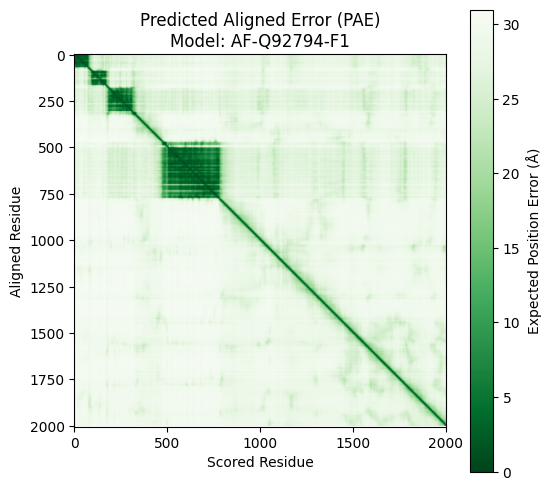

In [ ]:
#@markdown Now, choose one model ID to analyse the MSA.
#@markdown This code block will first visualise the structure and the PAE plot
model = "AF-Q92794-F1"#@param {type:"string"}

found= False
for entry in result:
    if entry["modelEntityId"] == model:
        plddt_url = entry["plddtDocUrl"]
        msa_url = entry["msaUrl"]
        pdbUrl = entry["pdbUrl"]
        paeDocUrl = entry["paeDocUrl"]
        found=True
        break

if not found:
    raise ValueError(f"Model {model} not found for UniProt ID {uniprot_id}.")


def plot_pae(pae_url):
    #print(f"Fetching PAE data from: {pae_url}")
    response = requests.get(pae_url)
    data = response.json()

    if isinstance(data, list) and len(data) > 0:
        pae_matrix = data[0]['predicted_aligned_error']
    else:
        print("Invalid PAE data format.")
        return

    # Plotting
    plt.figure(figsize=(6, 6))
    plt.imshow(pae_matrix, cmap='Greens_r', vmin=0, vmax=31)

    cb = plt.colorbar()
    cb.set_label('Expected Position Error (Å)')
    plt.title(f'Predicted Aligned Error (PAE)\nModel: {model}')
    plt.xlabel('Scored Residue')
    plt.ylabel('Aligned Residue')
    plt.grid(False)
    plt.show()

# Function to show protein structure and image
def show_structure_and_image(pdb_url, paeUrl, color="plDDT"):
    # Retrieve the PDB data from the URL
    pdb_data = requests.get(pdb_url).text
    # Create a 3Dmol.js view
    view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
    # Add the PDB data to the view
    view.addModel(pdb_data, 'pdb')

    if color == "plDDT":
        view.setStyle({'cartoon': {'colorscheme': {'prop': 'b', 'gradient': 'roygb', 'min': 50, 'max': 90}}})
    elif color == "rainbow":
        view.setStyle({'cartoon': {'color': 'spectrum'}})

    # Zoom to the structure
    view.zoomTo()
    display(view) # Display the 3D structure
    plot_pae(paeUrl) # Display PAE plot

show_structure_and_image(pdbUrl, paeDocUrl, "plDDT")


Remember to analyse the PAE and confidence scores from the AlphaFold Database

In [ ]:
#@markdown This code block will parse the MSA. It also prints the number of sequences found.

if plddt_url and msa_url:
    #print(f"--Fetching pLDDT from: {plddt_url}")
    plddt_response = requests.get(plddt_url)
    plddt_data = plddt_response.json()
    #print(plddt_data)

    plddt_scores = plddt_data['confidenceScore']
    residue_number = plddt_data['residueNumber']
    #print(f"Entry length: {len(plddt_scores)}")
    print(f"Successfully fetched pLDDT for {len(plddt_scores)} residues.")

    #print(f"--Fetching MSA from: {msa_url}")
    msa_response = requests.get(msa_url)
    msa_content = msa_response.text # Get the raw text of the .a3m file
    print("Successfully fetched MSA content.")

else:
    print(f"Error: Could not find URLs for model {model}")


def parse_a3m_content(a3m_content):
    """Parses the A3M content into a list of uppercase sequences."""
    sanitised_content = re.sub(r'[a-z]', '', a3m_content)

    alignment = AlignIO.read(StringIO(sanitised_content), "fasta")

    #convert to a simple list of strings
    sequences = [str(record.seq) for record in alignment]

    return sequences

print("Parsing A3M content...")
sequences = parse_a3m_content(msa_content)
query_seq = sequences[0]
print(f"Parsing complete. Found {len(sequences)} sequences.")


query_seq = sequences[0].replace("-", "").replace(".", "")
if len(query_seq) != len(plddt_scores):
    print(f"Warning: query length ({len(query_seq)}) != pLDDT length ({len(plddt_scores)}).")
    print("Plots may be misaligned; check A3M parsing and model selection.")


Successfully fetched pLDDT for 2004 residues.
Successfully fetched MSA content.
Parsing A3M content...
Parsing complete. Found 10151 sequences.


### How to interpret the following analyses

The goal of the following analyses is not to assess whether the AlphaFold model is “correct”, but to understand how much evolutionary information supports different regions of the prediction.

As you explore the plots below, focus on three questions:

1. Which regions of the sequence are consistently covered by many aligned sequences?
2. Do regions of low MSA coverage coincide with low AlphaFold confidence (pLDDT)?
3. Are there sharp transitions in coverage that might indicate domain boundaries, insertions, or flexible linkers?

Keeping these questions in mind will help connect the MSA statistics to biological and structural interpretation.


## <font color='#2895ef'> 3. MSA depth analysis

MSA Depth (or "Gap Coverage") is the count of sequences in the alignment that possess a non-gap residue at a specific position. It acts as a proxy for the amount of evolutionary information available for that specific part of the protein.

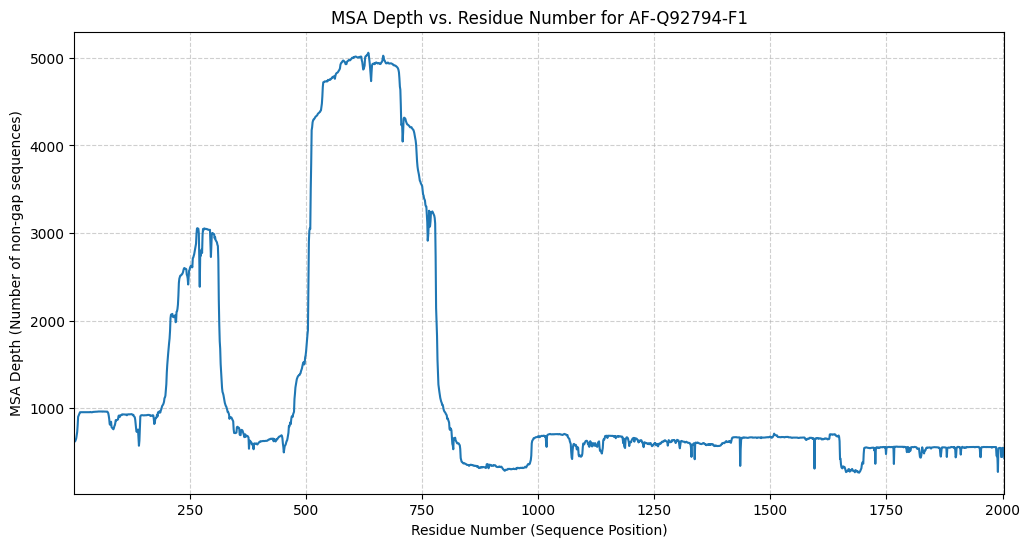

In [ ]:
#@markdown This code block will plot the MSA depth for the model entry ID given before

def get_msa_depth_from_content(sequences):
    """Calculates per-residue MSA depth from A3M file content."""

    seq_array = np.array([list(s) for s in sequences])

    non_gaps = (seq_array != '-') & (seq_array != '.')

    depths = np.sum(non_gaps, axis=0)
    return depths


# Calculate the MSA depths
msa_depths = get_msa_depth_from_content(sequences)

# Plotting
sequence_length = len(msa_depths)
residue_numbers = range(1, sequence_length + 1)
plt.figure(figsize=(12, 6))
plt.plot(residue_numbers, msa_depths)
plt.title(f"MSA Depth vs. Residue Number for {model}")
plt.xlabel("Residue Number (Sequence Position)")
plt.ylabel("MSA Depth (Number of non-gap sequences)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim(1, sequence_length)
plt.show()


# Per-residue MSA coverage

For each aligned position, we compute the number of sequences in the MSA that contain a non-gap residue at that position. This value is referred to here as the MSA coverage or per-residue depth.

High coverage indicates that many homologous sequences contribute information at that position, suggesting that the region is evolutionarily conserved and consistently aligned across the protein family. Low coverage indicates that few sequences support the position, which commonly corresponds to insertions, flexible regions, poorly conserved termini, or sequence-specific features.

Importantly, MSA coverage is not uniform along the sequence. Even proteins with deep MSAs can contain local drops in coverage, and these local features are often biologically meaningful rather than noise.

## Interpretation guide

* What does MSA depth measure?
MSA depth is a per-residue count of how many sequences in the alignment contribute a non-gap residue at that position. It indicates how much evolutionary information is available locally along the sequence, rather than summarising the MSA as a whole.

* How should depth be interpreted?
Regions with consistently high coverage are typically part of conserved regions and are well supported by evolutionary evidence.

Sharp drops in coverage often indicate insertions, flexible linkers, or regions that are not conserved across homologs.

Terminal regions frequently show lower coverage due to truncations or incomplete homologs in sequence databases.

* What does a depth of zero mean?
A depth of zero indicates that only the query sequence contains residues at that position, while all other sequences have gaps. This is a strong signature of a query-specific insertion or a low-complexity or disordered region that is not part of the conserved protein family core.

* What this metric does not capture
MSA depth reflects how many sequences contribute information, but not how diverse those sequences are. Highly similar sequences can inflate depth without adding independent evolutionary constraints. Diversity-aware metrics (such as effective sequence number) are discussed later.

In the next section, we compare MSA coverage to AlphaFold confidence scores (pLDDT) to assess whether regions of low confidence coincide with limited evolutionary support.

## <font color='#2895ef'> 4. Correlation: MSA depth vs. pLDDT

AlphaFold's confidence metric, **pLDDT** (predicted Local Distance Difference Test), estimates the local accuracy of the structure. We expect a strong correlation between Depth and pLDDT.

This first plot shows the MSA depth against a background coloured by the pLDDT score.

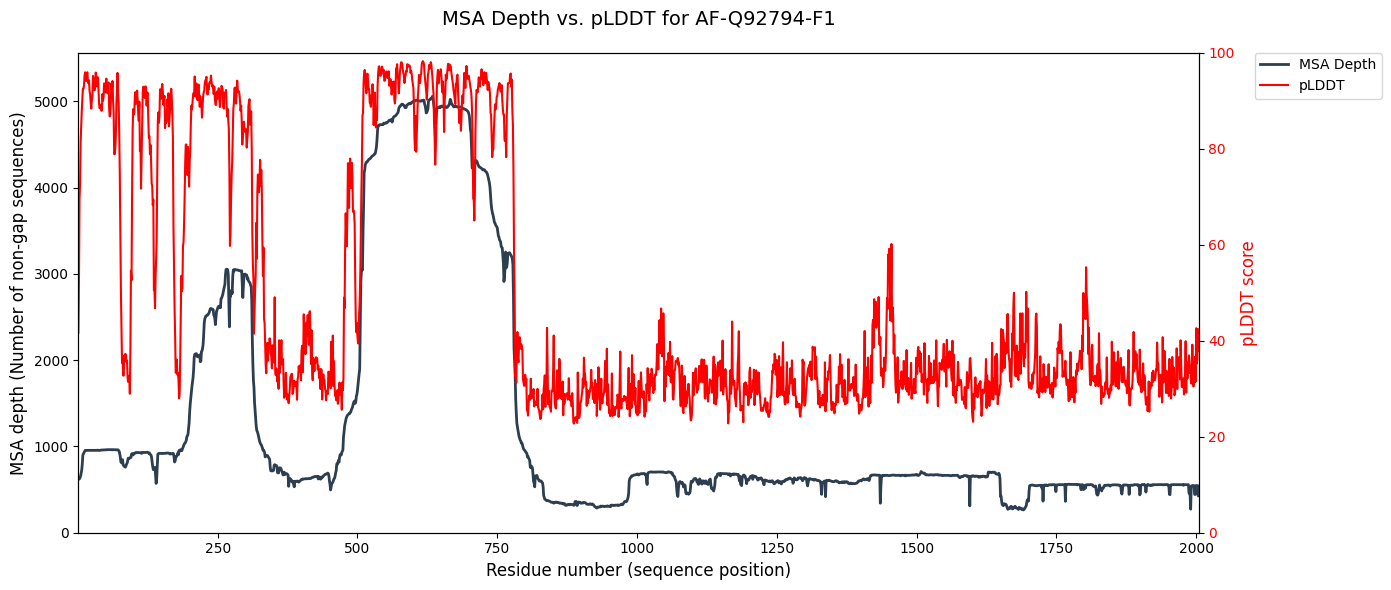

In [ ]:
#@markdown This plot shows the same data but with two separate y-axes (a "twin-axis" plot).

def plot_msa_depth_with_plddt_background(msa_depths, plddt_values, model_name, figsize=(14, 6)):
    """
    Plot MSA depth with pLDDT confidence regions as background colors

    Parameters:
    - msa_depths: list of MSA depths for each residue position
    - plddt_values: list of pLDDT values for each residue position
    - model_name: name of the model for the title
    - figsize: tuple for figure size
    """

    sequence_length = len(msa_depths)
    residue_numbers = range(1, sequence_length + 1)

    # Create the plot figure and axes
    fig, ax = plt.subplots(figsize=figsize)

    # Plot MSA depth as a line
    line = ax.plot(residue_numbers, msa_depths, linewidth=2, color='#2c3e50',
                   label='MSA Depth', marker='', markersize=1)

    # Customize the plot
    ax.set_title(f"MSA Depth vs. pLDDT for {model_name}", fontsize=14, pad=20)
    ax.set_xlabel("Residue number (sequence position)", fontsize=12)
    ax.set_ylabel("MSA depth (Number of non-gap sequences)", fontsize=12)

    # Set axis limits
    ax.set_xlim(1, sequence_length)
    ax.set_ylim(0, max(msa_depths) * 1.1)  # Add 10% padding at top

    # Add legend
    ax.legend(loc='upper right', framealpha=0.9)

    # Optional: Add secondary y-axis for pLDDT values
    ax2 = ax.twinx()
    ax2.plot(residue_numbers, plddt_values, color='red', alpha=1.0, linewidth=1.5,
             label='pLDDT')
    ax2.set_ylabel('pLDDT score', fontsize=12, color='red')
    ax2.set_ylim(0, 100)
    ax2.tick_params(axis='y', labelcolor='red')

    # Combine legends
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.tight_layout()
    return fig, ax

fig1, ax1 = plot_msa_depth_with_plddt_background(msa_depths, plddt_scores, model)
plt.show()

### Relating MSA coverage to AlphaFold confidence

AlphaFold confidence scores (pLDDT) reflect how certain the model is about local atomic positions. While many factors contribute to pLDDT, a major driver is the availability of evolutionary information from the MSA.

By comparing per-residue MSA coverage with pLDDT scores, we can assess whether regions of low confidence are associated with limited evolutionary support, or whether low confidence arises despite good MSA coverage.

## Typical patterns include:
- High coverage and high pLDDT: well-supported, structurally reliable regions.
- Low coverage and low pLDDT: likely flexible, disordered, or poorly constrained regions.
- High coverage but low pLDDT: potential conformational variability or alignment heterogeneity.
- Low coverage but high pLDDT: regions where the model relies more heavily on learned priors; interpret fine structural details with caution.


## <font color='#2895ef'> 5. Sequence coverage landscape

The MSA raster plot provides a compact overview of how sequences in the alignment cover the query protein along its full length. Each row corresponds to a sequence in the MSA, sorted by sequence identity to the query, and each column corresponds to an aligned position.

Color intensity reflects sequence identity to the query, while gaps are shown in white. Regions where many sequences contain gaps indicate low coverage, meaning that few homologs contribute information at those positions.

Sorting sequences by identity helps distinguish between broadly conserved regions ( i.e. where even distant homologs align consistently)and regions that are only present in closely related sequences.

This visualisation can be used to identify:

* conserved blocks that are well aligned across most homologs,
* insertions or deletions that are present only in a subset of sequences,
* sequences that only partially cover the query,
* abrupt changes in alignment coverage that may correspond to domain boundaries or flexible linkers.

On the plot:

* X-axis: Aligned residue positions along the query sequence
* Y-axis: Individual MSA sequences, sorted by sequence identity to the query
* Color: Sequence identity (red = high identity, blue = low identity; white = gap)


Parsing MSA and creating plot matrix...
Matrix created with shape: (10151, 2004)


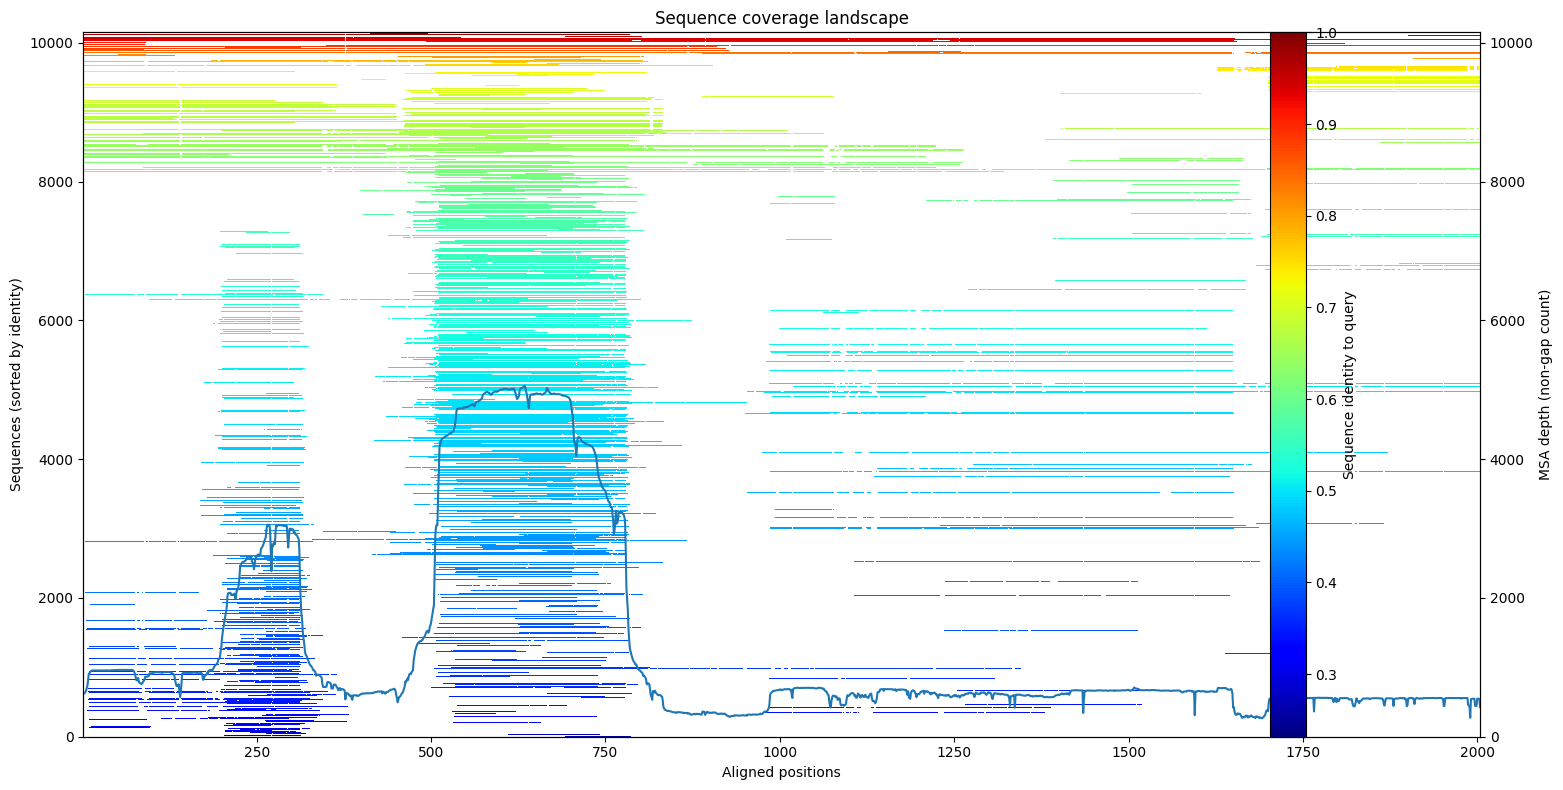

In [ ]:
#@markdown This code block will plot a raster plot (i.e. looks like the plot you get from ColabFold)

def create_msa_plot_matrix(sequences):
    """
    Build a matrix for imshow where each row is a sequence and each column is the
    per-sequence identity (constant across the row), masked to NaN at gap positions.

    Identity is computed over positions where BOTH:
      - query has a non-gap residue, and
      - the sequence has a non-gap residue.
    """
    import numpy as np

    seq_array = np.array([list(s) for s in sequences])
    query = seq_array[0]

    # define gaps
    gap_chars = np.isin(seq_array, ['-', '.'])
    query_is_gap = np.isin(query, ['-', '.'])

    # valid positions for identity: query non-gap AND sequence non-gap
    valid = (~query_is_gap)[None, :] & (~gap_chars)

    # matches only count where valid
    matches = (seq_array == query[None, :]) & valid

    denom = valid.sum(axis=1)
    # avoid divide-by-zero for pathological rows
    seq_identities = np.divide(
        matches.sum(axis=1),
        denom,
        out=np.zeros_like(denom, dtype=float),
        where=denom > 0
    )

    # sort rows by identity (low -> high, like ColabFold)
    sorted_indices = np.argsort(seq_identities)
    sorted_identities = seq_identities[sorted_indices]
    sorted_seq_array = seq_array[sorted_indices]

    # matrix for plotting: identity repeated across columns, with gaps masked
    plot_matrix = np.tile(sorted_identities[:, None], (1, seq_array.shape[1]))
    is_gap_sorted = np.isin(sorted_seq_array, ['-', '.'])
    plot_matrix[is_gap_sorted] = np.nan

    return plot_matrix, sorted_identities, sorted_indices


if 'sequences' in locals() and 'msa_depths' in locals():
    print("Parsing MSA and creating plot matrix...")
    plot_matrix, sorted_identities, sorted_indices = create_msa_plot_matrix(sequences)
    num_hits, seq_length = plot_matrix.shape
    print(f"Matrix created with shape: {plot_matrix.shape}")

    plt.figure(figsize=(15, 8))
    ax = plt.gca()

    # ---Sequence Coverage Raster plot ---
    cmap = plt.get_cmap('jet')
    cmap.set_bad(color='white')

    im = ax.imshow(
        plot_matrix,
        aspect='auto',
        origin='lower',
        cmap=cmap,
        interpolation='nearest',
        extent=[1, seq_length, 0, num_hits])

    ax.plot(msa_depths, color='black', linewidth=1.5)

    # --- Colorbar and Labels ---
    cbar = plt.colorbar(im, ax=ax, pad=0.1)
    cbar.set_label("Sequence identity to query")
    ax.set_xlabel("Positions")
    ax.set_ylabel("Sequences")
    ax.set_xlim(1, seq_length + 1)
    ax.set_ylim(0, num_hits)
    plt.title("Sequence coverage")
    plt.tight_layout()
    plt.savefig("msa_coverage_plot.png")
    plt.show()

else:
    print("Error: Please run previous cells to get 'sequences' and 'msa_depths'.")


**What to look for:**
* **"Rainbow" Distribution:** A healthy MSA contains sequences spanning a broad range of identities (30% to 90%). This diversity drives the detection of co-evolution.
* **"Deserts" (White Regions):** Vertical bands of white indicate regions where most homologs have deletions. These often correspond to flexible loops or organism-specific insertions.

### Limitations of this analysis

MSA coverage reflects how many sequences contribute information at each position, but it does not measure sequence diversity or redundancy. Highly similar sequences may inflate coverage without adding independent evolutionary signal.

As a result, coverage should be interpreted as a necessary but not sufficient indicator of MSA quality.
